<a href="https://colab.research.google.com/github/rahulkr6061/DS_Projects/blob/main/Loan_Eligiblity_using_Mobile_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading data from kaggle


In [1]:
!pip install kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json file when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulkgp6061","key":"d51e1b3cd8378346cdf2d52595537e33"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d pratikgarai/mobile-phone-specifications-and-prices

Dataset URL: https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices
License(s): unknown


In [5]:
!unzip mobile-phone-specifications-and-prices.zip

Archive:  mobile-phone-specifications-and-prices.zip
  inflating: ndtv_data_final.csv     


## Import libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_csv('/content/ndtv_data_final.csv')

In [25]:
df.head()

,Unnamed: 0,Name,Brand,Model,Battery capacity (mAh),Screen size (inches),Touchscreen,Resolution x,Resolution y,Processor,...,Rear camera,Front camera,Operating system,Wi-Fi,Bluetooth,GPS,Number of SIMs,3G,4G/ LTE,Price
0,0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,...,48.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,...,64.0,16.0,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,106900
3,3,iPhone 11,Apple,iPhone 11,3110,6.10,Yes,828,1792,6,...,12.0,12.0,iOS,Yes,Yes,Yes,2,Yes,Yes,62900
4,4,LG G8X ThinQ,LG,G8X ThinQ,4000,6.40,Yes,1080,2340,8,...,12.0,32.0,Android,Yes,Yes,Yes,1,No,No,49990


In [26]:
df.drop(['Name','Unnamed: 0'], axis=1, inplace=True)

# Identify categorical and numerical columns
categorical_cols = ['Brand', 'Model', 'Touchscreen', 'Processor',
                    'Operating system', 'Wi-Fi', 'Bluetooth', 'GPS', '3G', '4G/ LTE']
numerical_cols = ['Battery capacity (mAh)', 'Screen size (inches)', 'Resolution x', 'Resolution y',
                  'RAM (MB)', 'Internal storage (GB)', 'Rear camera', 'Front camera',
                  'Number of SIMs', 'Price']

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])


In [13]:
# Convert binary categorical columns with 'Yes'/'No' into 1/0
binary_cols = ['Touchscreen', 'Wi-Fi', 'Bluetooth', 'GPS', '3G', '4G/ LTE']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})


In [14]:
# For remaining categorical columns, apply Label Encoding
le = LabelEncoder()
for col in ['Brand', 'Model', 'Processor', 'Operating system']:
    df[col + '_enc'] = le.fit_transform(df[col])


In [15]:
# Define final feature list: using numerical features and encoded versions of categorical variables
feature_cols = numerical_cols + ['Brand_enc', 'Model_enc', 'Processor_enc', 'Operating system_enc'] + binary_cols


In [16]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])
df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)


## Unsupervised Clustering to Create Proxy Labels


In [17]:

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)


In [18]:
# Assume the cluster with the highest average 'Price' represents premium devices
cluster_prices = df.groupby('Cluster')['Price'].mean()
premium_cluster = cluster_prices.idxmax()

# Create a proxy label for loan eligibility: 1 if device is premium, 0 otherwise
df['Loan_Eligibility'] = (df['Cluster'] == premium_cluster).astype(int)

print("\nAverage Price per Cluster:")
print(cluster_prices)
print(f"\nAssuming cluster {premium_cluster} is premium; devices in this cluster are marked as Eligible (1).")



Average Price per Cluster:
Cluster
0    12580.729433
1     5924.275811
2    34953.276119
Name: Price, dtype: float64

Assuming cluster 2 is premium; devices in this cluster are marked as Eligible (1).


## Prepare features and target


In [19]:
X = df[feature_cols]
y = df['Loan_Eligibility']



## Split into training and testing sets (80/20 split)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train an XGBoost classifier


In [20]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:31:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Make predictions on the test set


In [27]:
y_pred = model.predict(X_test)

## Evaluate model performance


In [21]:
accuracy = accuracy_score(y_test, y_pred)
print("\nSupervised Model Evaluation:")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Supervised Model Evaluation:
Accuracy: 0.9926470588235294

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       253
           1       0.95      0.95      0.95        19

    accuracy                           0.99       272
   macro avg       0.97      0.97      0.97       272
weighted avg       0.99      0.99      0.99       272

Confusion Matrix:
[[252   1]
 [  1  18]]


## Feature Importance Visualization


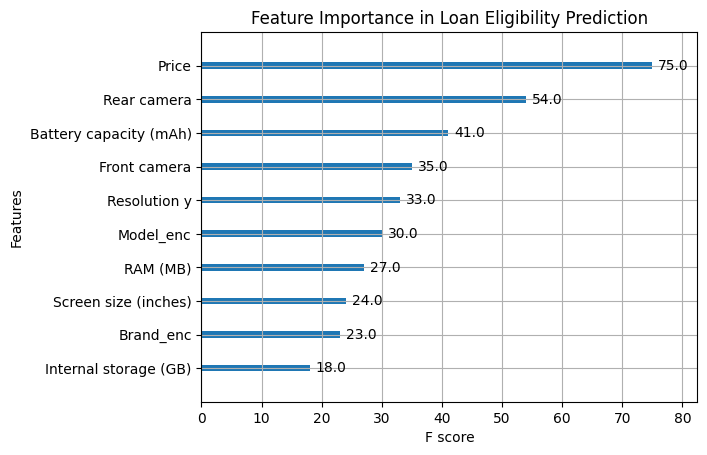

In [22]:
xgb.plot_importance(model, max_num_features=10)
plt.title("Feature Importance in Loan Eligibility Prediction")
plt.show()
